# Table of Contents
* [build and  update](#build-and--update)
	* [load](#load)
	* [stage1](#stage1)
	* [stage3](#stage3)
	* [inspect](#inspect)
* [parsing](#parsing)
	* [run](#run)
	* [exp](#exp)
* [mkdocs/ s3 dev](#mkdocs/-s3-dev)
* [clean and spellcheck](#clean-and-spellcheck)
* [hide](#hide)
	* [old build and update ds](#old-build-and-update-ds)


In [76]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2

In [6]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

# build and  update

## load

In [31]:
from amt_utils import flintstones_pipeline
from amt_utils.mturk import unpickle_this, pickle_this

In [32]:
selection_metadata_dir = 'Flintstone_Shots_GIF_Selection'

with open(os.path.join(selection_metadata_dir, 'beta_gif_names.json')) as f:
    beta_videos = json.load(f)
        
with open(os.path.join(selection_metadata_dir, 'production_gif_names.json')) as f:
    production_videos = json.load(f)

In [33]:
processed_stage_1_a = unpickle_this('./stage_1/pickeled_results/processed_stage1_boxes.pkl')

processed_stage_1_b = unpickle_this('./stage_1/pickeled_results/stage_1b_prod_all_boxes_8_29.pkl')

stage_3a_settings = unpickle_this('stage_3/stage3_prod1_2_settings.pkl')

stage_3b_descriptions =  unpickle_this('stage_3/stage3_prod1_2_descriptions.pkl')

stage_3b_parses = unpickle_this('stage_3/stage3_prod1_2_descriptions_parses.pkl')

stage_4a_con_boxes = unpickle_this('stage_4/stage_4b_con_batch_2.pkl')

stage_4b_objects = unpickle_this('stage_4/obj_data.pkl')

In [34]:
# vid_bins = unpickle_this('vid_bin_assignments.pkl')

# vid_bin_lookup = {}
# for k, vals in vid_bins.items():
#     for v in vals:
#         vid_bin_lookup[v] = k

In [35]:
with open('./json_data/ds_production.json') as f:
    prod_batch_1 = json.load(f)[:20000]

In [36]:
prod_batch_1 = [vid['globalID'] for vid in prod_batch_1]

## stage1

In [37]:
# prod_dataset = flintstones_pipeline.FlintstonesDataset([vid_id])
prod_dataset = flintstones_pipeline.FlintstonesDataset(prod_batch_1)

In [38]:
prod_dataset.update_s1a(processed_stage_1_a)

In [39]:
# sorted_vids = prod_dataset.sorted_by_episode()
# prod_dataset

In [40]:
prod_dataset = flintstones_pipeline.FlintstonesDataset(prod_batch_1)
prod_dataset.update_s1a(processed_stage_1_a)
prod_dataset.update_s1b(processed_stage_1_b)

## stage3

In [44]:
prod_dataset.update_s3a(stage_3a_settings)

In [45]:
prod_dataset.update_s3b(stage_3b_descriptions)

In [46]:
go_vids = prod_dataset.filter_videos({'go': True})

In [16]:
# pickle_this(go_vids, 'v0p2_to_parse.pkl')

In [17]:
# dataset_to_json(go_vids, '0p2_to_parse')

## stage4

### hide

In [18]:
ds_sample_file = '/Users/schwenk/wrk/animation_gan/ai2-vision-animation-gan/data_store/dataset/dataset_v0p3_sample_coref.json'

with open(ds_sample_file, 'r') as f:
    ds_sample = json.load(f)

o_sample_vids = set([vid['globalID'] for vid in ds_sample])

original_sample = [vid for vid in go_vids if vid.gid() in o_sample_vids]

In [536]:
interesting_vid_descs = {vid.gid(): vid.description() for vid in go_vids if 'phone' in vid.description()}

## inspect

In [ ]:
prod_dataset = flintstones_pipeline.FlintstonesDataset(prod_batch_1)
prod_dataset.update_s1a(processed_stage_1_a)
prod_dataset.update_s1b(processed_stage_1_b)

In [ ]:
prod_dataset.update_s3a(stage_3a_settings)

In [ ]:
vid_id = 's_02_e_29_shot_014705_014779'
inspect_vid = prod_dataset.get_video(vid_id)
inspect_vid = prod_dataset.filter_videos({'go': True})[50]

In [ ]:
# inspect_vid

In [ ]:
# inspect_vid.display_gif()

In [ ]:
dfs = inspect_vid.display_bounding_boxes()
three_frames  = inspect_vid.display_keyframes()

In [ ]:
three_frames.save(local_path + inspect_vid.gid() + '_keyframes.png')
dfs.save(local_path + inspect_vid.gid() + '_bboxes.png')

In [ ]:
# three_frames

In [ ]:
local_path = '/Users/schwenk/wrk/animation_gan/ai2-vision-animation-gan/documentation/images/'

img_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/documentation/images/'

In [ ]:
inspect_vid.characters_present()

In [ ]:
char_names_by_id = [char.name() for char in sorted(inspect_vid.data()['characters'], key=lambda x: x.char_id())]

In [ ]:
char_names_by_id

# parsing 

## run

In [4]:
import spacy
from nltk.parse.stanford import StanfordParser
from nltk.tokenize import sent_tokenize
from nltk.tree import ParentedTree
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPParser

from phrase_cues.parsing import parse_video
from phrase_cues.parsing import Tree, Node, format_parse

In [8]:
def dataset_to_json(dataset, version, out_dir='dataset'):
    to_json = copy.deepcopy(dataset)
    for vid in to_json:
        vid.vid_data['characters'] = [char.data() for char in vid.vid_data['characters']]

    ds_json = [vid.vid_data for vid in to_json]
    out_file = os.path.join(out_dir, 'dataset_v{}.json'.format(version))
    with open(out_file, 'w') as f:
        json.dump(ds_json, f, sort_keys=True, indent=4)

In [24]:
nlp = spacy.load('en')
core_nlp_base = '/Users/schwenk/wrk/animation_gan/phrase_cues/deps/stanford_core_nlp/stanford-corenlp-full-2017-06-09/'

const_parse_path = '/Users/schwenk/wrk/animation_gan/build_dataset/dataset'
const_parse_dir = 'const_parses'

core_parser = CoreNLPParser(url='http://localhost:9000')    

In [25]:
for vid in tqdm(go_vids):
    try:
        parse_video(vid, nlp, core_parser)
    except:
        print(vid.gid())

100%|██████████| 8504/8504 [06:07<00:00, 23.13it/s]


In [26]:
coref_res = unpickle_this('pickled_data/coref_results_full_1.pkl')

In [27]:
for vid in go_vids:
    vid.vid_data['parse']['coref'] = coref_res[vid.gid()] 

In [8]:
go_vids = unpickle_this('./pickled_data/dataset_full8500_0p4p5.pkl')

In [9]:
len(go_vids)

8504

In [ ]:
pickle_this(go_vids, './pickled_data/dataset_full8500_0p4p5.pkl')

In [11]:
dataset_to_json(go_vids, '0p5')

In [12]:
test_vid = go_vids[500]

In [14]:
char_bbox_array = np.load('./object_tracking/interpolated_char_bboxes/s_01_e_26_shot_021802_021876_char_0.npy')

In [15]:
vid_gif = test_vid.display_gif()

In [22]:
# vid_gif

In [23]:
find_vid = [vid for vid in go_vids if 'their arms' in vid.vid_data['description']]

In [25]:
find_vid

[{
     "characters": [
         {
             "char_data": {
                 "characterID": "s_03_e_05_shot_024255_024329_char_0",
                 "characterName": "fred",
                 "interactsWith": {
                     "name": "",
                     "positionID": ""
                 },
                 "nearbyObject": "",
                 "rectangles": [
                     [
                         262,
                         99,
                         478,
                         476
                     ],
                     [
                         272,
                         105,
                         463,
                         479
                     ],
                     [
                         262,
                         93,
                         466,
                         479
                     ]
                 ]
             },
             "properties": {
                 "char_base": "https://s3-us-west-2.amazonaws.com/ai

## exp

In [545]:
pickle_this(original_sample, 'dataset_sample_0p4p5.pkl')

In [552]:
td1 = 'Fred is leaning up against his car. He looks very tired, his shoulders are shrugged, he says something and then lets his shoulders down. Then he looks away.'

In [561]:
len(go_vids)

8504

In [33]:
videos_by_desc_leng = {vid.gid(): len(vid.vid_data['parse']['constituent_parse']) for vid in go_vids}

In [34]:
vid_len_lists = defaultdict(list)
for k, v in videos_by_desc_leng.items():
    vid_len_lists[v].append(k)

In [42]:
single_sent_vids = [vid for vid in go_vids if vid.gid() in set(vid_len_lists[3])]

In [43]:
len(single_sent_vids)

1053

In [46]:
pickle_this(single_sent_vids, 'pickled_data/three_sent_vids.pkl')

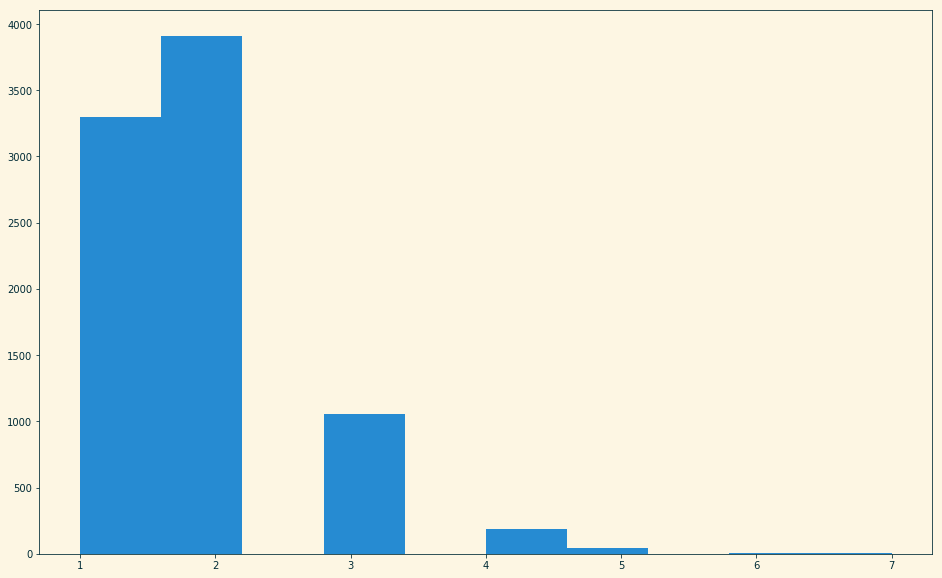

In [45]:
_ = pd.Series(videos_by_desc_leng).hist()

In [562]:
pickle_this(go_vids, 'flinstones_0p4_full_to_obj_anno.pkl')

In [559]:
tds = [sent.split() for sent in td1.split('.')][:-1]

In [498]:
td = nlp('musician with red hair playing base')

In [342]:
test_vid = test_vids[0]

In [500]:
test_vid = [v for v in original_sample if v.gid() == 's_02_e_20_shot_029247_029321'][0]

In [514]:
ntl = parse_video(test_vid, nlp, core_parser)
nltk_tree = ParentedTree.convert(ntl) 

In [30]:
# test_vid.vid_data['parse']

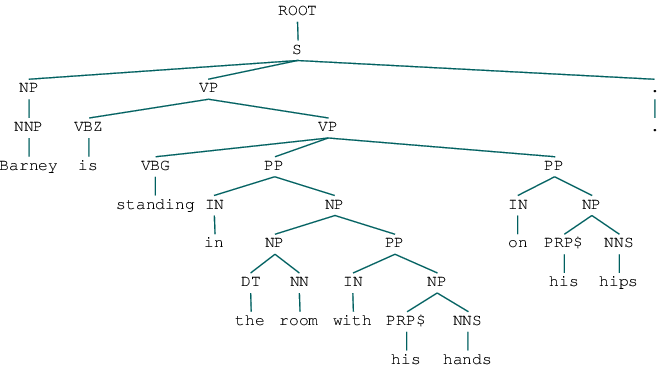

In [511]:
nltk_tree[0]

In [427]:
child_subtrees = list(nltk_tree.subtrees())

In [431]:
tvp = child_subtrees[5]

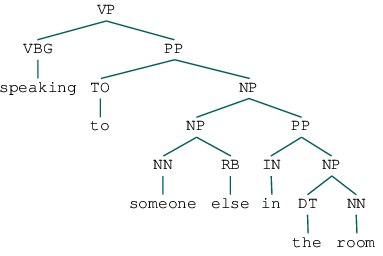

In [432]:
tvp

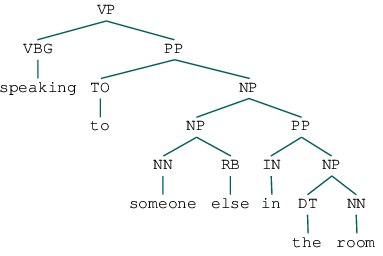

In [437]:
list(tvp.subtrees())[1].parent()

In [438]:
child_height = list(tvp.subtrees())[1].height()
nd_children = [str(tree.treeposition()) for tree in list(tvp.subtrees()) if tree.parent() == list(tvp.subtrees())[0]]

In [439]:
nd_children

['(1, 1, 0)', '(1, 1, 1)']

In [421]:
tt1 = list(tvp.subtrees())[4]

In [449]:
l0 = test_tree.leaves[4]
l0.value

[nd.value for nd in l0.parent.parent.children]

'NN someone'

In [56]:
tst1 = list(ts1.subtrees())[6]

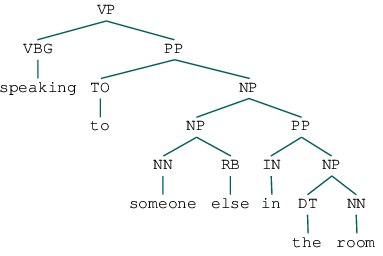

In [57]:
tst1.label

In [61]:
parented_trees = [ParentedTree.convert(sent) for sent in ts1]

In [66]:
pt1 = parented_trees[0]

In [419]:
pst5 = list(pt1.subtrees())[5]

In [420]:
type(pst5)

nltk.tree.ParentedTree

**coref**

In [487]:
prev_ds = unpickle_this('./pickled_data/flinstones_v0p3.pkl')

In [488]:
for vid in original_sample:
    vid.vid_data['parse']['coref'] = coref_res[vid.gid()] 

In [283]:
list(coref_res.values())[4] 

{'clusters': [((0, 0), (15, 15), (20, 20))],
 'named_clusters': [['Wilma', 'She', 'her']]}

In [315]:
dataset_to_json(original_sample, '0p4_sample')

In [456]:
test_vid = original_sample[5]

In [458]:
test_tree = unpickle_this('../ai2-vision-animation-gan/data_store/dataset/const_parses/' + test_vid.gid() + '_sent_0.pkl')

In [461]:
l0 = test_tree.leaves[4]
l0.value

'DT the'

In [466]:
[nd for nd in l0.parent.parent.children][1].children[1].value

'NN room'

In [ ]:
[nd for nd in l0.parent.parent.children][1].children[1].value

In [ ]:
[nd for nd in l0.parent.parent.children][1].children[1].value

In [468]:
trn = test_tree.root_node

In [484]:
trn.children[0].children[1].children[1].parent.value

'VP'

In [550]:
selected_vid = [v for v in original_sample if v.gid() == 's_02_e_20_shot_029247_029321'][0]

In [551]:
selected_vid.vid_data['parse']

{'constituent_parse': ['const_parses/s_02_e_20_shot_029247_029321_sent_0.pkl',
  'const_parses/s_02_e_20_shot_029247_029321_sent_1.pkl'],
 'coref': {'clusters': [((0, 1), (7, 8))],
  'named_clusters': [['Barney', 'his']]},
 'noun_phrase_chunks': {'chunks': [(0, 1),
   (4, 6),
   (7, 9),
   (10, 12),
   (13, 14),
   (17, 18),
   (18, 19),
   (25, 26)],
  'named_chunks': ['Barney',
   'the room',
   'his hands',
   'his hips',
   'He',
   'someone',
   'who',
   'he']},
 'pos_tags': [[('Barney', 'NNP'),
   ('is', 'VBZ'),
   ('standing', 'VBG'),
   ('in', 'IN'),
   ('the', 'DT'),
   ('room', 'NN'),
   ('with', 'IN'),
   ('his', 'PRP$'),
   ('hands', 'NNS'),
   ('on', 'IN'),
   ('his', 'PRP$'),
   ('hips', 'NNS'),
   ('.', '.')],
  [('He', 'PRP'),
   ('is', 'VBZ'),
   ('talking', 'VBG'),
   ('to', 'TO'),
   ('someone', 'NN'),
   ('who', 'WP'),
   ('can', 'MD'),
   ('not', 'RB'),
   ('be', 'VB'),
   ('seen', 'VBN'),
   (',', ','),
   ('and', 'CC'),
   ('he', 'PRP'),
   ('looks', 'VBZ'),
   

# mkdocs/ s3 dev

In [334]:
video_mkd_template = """## Video ID {}
![animation_frames]({})

![bounding_boxes]({})

![animation]({})

### Description
{}

#### Setting
{}

#### Characters
{}

### Parse
#### constituency parses
{}

#### noun phrase chunks
{}

#### coreference clusters
{}

- - -
"""

s3_doc_base_uri = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/documentation/images/'

local_path = '/Users/schwenk/wrk/animation_gan/ai2-vision-animation-gan/documentation/images/'

img_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/documentation/images/'

from nltk.draw.tree import TreeView

def paginate_docs(videos, page_size=50):
    num_sort = sorted(videos, key=lambda x: x.gid())
    for i in range(0, len(num_sort), page_size):
        yield num_sort[i:i + page_size]
        
def write_mkd_doc(doc, fp):
    with open(fp, 'w') as f:
        f.write(doc)
        
def format_characters(id_name_pairs):
    char_base = ''
    for char_id, char_name in id_name_pairs:
        char_base += '\tcharacter ' + char_id.rsplit('_', maxsplit=1)[-1] + ': ' + char_name + '\n\n'
    return char_base

def gen_and_save_doc_images(video):
    three_frames  = video.display_keyframes()
    frame_bboxes = video.display_bounding_boxes()
    
    three_frames.save(local_path + video.gid() + '_keyframes.png')
    frame_bboxes.save(local_path + video.gid() + '_bboxes.png')
    
def draw_parse_trees(video):
    parsed_sents = parse_video(video, nlp, core_parser)
    for idx, sent in enumerate(parsed_sents):
        tree_name = local_path + video.gid() + '_sent_' + str(idx) + '_parse_tree'
        TreeView(sent)._cframe.print_to_file(tree_name + '.ps')
        _ = os.system('convert ' + tree_name + '.ps ' +  tree_name + '.png')
        _ = os.system('rm ' + tree_name + '.ps')
    
def gen_video_mkd(video):
    entry_args = [
        video.gid(),
        s3_doc_base_uri + video.gid() + '_keyframes.png',
        s3_doc_base_uri + video.gid() + '_bboxes.png',
        video.display_gif(True),
        video.description(),
        '\t' + video.setting(),
        format_characters(video.characters_present()),
        '\n\n'.join('![con_parse]({})'.format(s3_doc_base_uri + video.gid() + '_sent_' + str(sent_idx) + '_parse_tree.png') for sent_idx in range(len(video.vid_data['parse']['constituent_parse']))),
        '\t' + '\n\n\t'.join(video.vid_data['parse']['noun_phrase_chunks']['named_chunks']),
        '\t' + '\n\n\t'.join([' : '.join(cluster) for cluster in video.vid_data['parse']['coref']['named_clusters']])
    ]
    
    return video_mkd_template.format(*entry_args)
    vid_data['parse']['']

def doc_video_group(dataset, make_images=True):
    page_filenames = {}
    for idx, videos in enumerate(list(paginate_docs(dataset, 10))):
        idx += 1
        page_md = '\n\n\n\n'.join([gen_video_mkd(vid) for vid in videos])
        page_name = 'video group {0:0{width}}'.format(idx, width=2)
        page_filenames[page_name] = page_name.replace(' ', '_') + '.md'
        if make_images: 
            _ = [gen_and_save_doc_images(vid) for vid in videos]
            _ = [draw_parse_trees(vid) for vid in videos]
        write_mkd_doc(page_md, './documentation/docs/' + page_filenames[page_name])
    write_mkdocs_config(page_filenames, 'Flintstones Dataset Explorer')
    

def write_mkdocs_config(page_names, site_name):
    yml_head = """site_name: {}
theme: null
theme_dir: './material'
extra:
   font:
      text: Oxygen
      code: Oxygen
pages:
   - home: index.md
""".format(site_name)


    padding1 = '   '
    padding2 = '    '
    with open('./documentation/mkdocs.yml', 'w') as f:
        f.write(yml_head)
        for k, v in sorted(page_names.items()):
            f.write(''.join([padding1, '- ', k, ': ', v, '\n']))
#         for k, vals in sorted(category_group_names.items()):
#             f.write(''.join([padding1, '- ', k, ': ', '\n']))
#             for v in vals:
#                 f.write(''.join([padding2, '- ', v, ': ', v, '\n']))

In [332]:
# test_ds = random.sample(prev_ds, 100)

In [333]:
doc_video_group(original_sample, False)

# run interpolation

In [237]:
def interpolate_rects(anno_rects, anno_frames ,num_frames):
    start_frames_id = [None]*num_frames
    end_frames_id = [None]*num_frames
    for i in range(0,anno_frames[0]+1):
        start_frames_id[i] = 0
        end_frames_id[i] = 1

    for i in range(anno_frames[-1],num_frames):
        start_frames_id[i] = len(anno_frames)-2
        end_frames_id[i] = len(anno_frames)-1

    for j in range(len(anno_frames)-1):
        for i in range(anno_frames[j]+1,anno_frames[j+1]+1):
            start_frames_id[i] = j
            end_frames_id[i] = j+1 

    rects = np.zeros([num_frames, 4])
    for i in range(num_frames):
        rects[i,:] = extrapolate_rect(
            i,
            anno_rects[start_frames_id[i]],
            anno_rects[end_frames_id[i]],
            anno_frames[start_frames_id[i]],
            anno_frames[end_frames_id[i]])[:]

    return rects


def extrapolate_rect(idx,start_rect,end_rect,start_frame,end_frame):
    num_frames = end_frame - start_frame + 1
    rect = [None]*4
    d_start = (idx - start_frame)/(num_frames-1)
    d_end = 1 - d_start
    for j, (c1,c2) in enumerate(zip(start_rect,end_rect)):
        rect[j] = d_end*c1 + d_start*c2

    return rect

In [236]:
#     for _,video_anno in tqdm(enumerate(annos)):
globalID = video_anno['globalID']
for char_anno in video_anno['characters']:
    char_id = char_anno['characterID']
    rects = interpolate_rects(
        char_anno['rectangles'],
        [9,39,69],
        75)

    rects = rects.astype(np.int32)
    outfile = os.path.join(
        FLAGS.outdir,
        char_id + '.npy')

    np.save(outfile,rects)            

In [ ]:
rects = interpolate_rects(
        char_anno['rectangles'],
        [9,39,69],
        75)

In [243]:
test_rects = test_vid.vid_data['characters'][0].rect()

In [246]:
interp_rects = interpolate_rects(test_rects, [9,39,69], 75)

# visualize interpolation

In [30]:
frame_dir = './object_tracking/vid_arr_data/'
bbox_dir = 'object_tracking/interpolated_char_bboxes/'

In [73]:
test_vid = go_vids[3]

In [258]:
new_dim = 128
owidth = 640
oheight = 480

scale_down = new_dim / owidth
asp_ratio = owidth / oheight

def draw_bbox(frame_arr_square, char_bb):
    frame_arr = cv2.resize(frame_arr_square, None, fx = asp_ratio, fy=1)
    char_bb = char_bb.reshape(2, 2)
    char_bb[:, 0] = char_bb[:, 0] * scale_down * asp_ratio
    char_bb[:, 1] = char_bb[:, 1] * scale_down * asp_ratio
    char_bb = char_bb.astype(int)
#     open_cv_image = frame_1[:, :, ::].copy()
    return pil.fromarray(cv2.rectangle(frame_arr, tuple(char_bb[0]), tuple(char_bb[1]), color=(0, 255, 255), thickness=1))

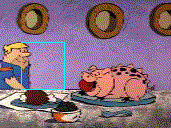

In [260]:
frame_arr_data = np.load(frame_dir + test_vid.gid() + '.npy')
char_bboxes = np.load(bbox_dir + test_vid.gid() + '_char_0.npy')

interp_img_seq = [draw_bbox(frame_arr_data[frame_n], char_bboxes[frame_n]) for frame_n in range(frame_arr_data.shape[0])]

outfile = test_vid.gid() + '_interp.gif'
interp_img_seq[0].save(outfile, save_all=True, optimize=True, duration=42, append_images=interp_img_seq[1:])

with open(outfile ,'rb') as f:
    display(Image(data=f.read(), format='png'))

In [255]:
# test_vid.description()

In [256]:
# test_vid.display_bounding_boxes()

In [ ]:
# prod_dataset.get_video('s_05_e_08_shot_037752_037826').display_gif()

# clean and spellcheck

In [55]:
import enchant
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

from fuzzywuzzy import fuzz
import difflib
import diff_match_patch

dmp = diff_match_patch.diff_match_patch()

edict = enchant.Dict("en_US")
anglo_edict = enchant.Dict("en_UK")
cached_sw = stopwords.words("english") + list(string.punctuation)

#         edict.add(word)

In [ ]:
other_chars_names = ['gazoo', 'lodabricks', 'slaghoople', 'poobaah']

In [ ]:
other_words = ['bandana', 'tv', 'bandana', 'bowtie', 'sabretooth', 'creepella', 'polkadot', 
               'turban', 'monical', 'unibrow', 'accordion', 'boutineer', 'handkerchief', 'xray', 
               'onesie', 'midcentury', 'cafe', 'squatty', 'earings']

In [ ]:
words_to_remove = ['whine', 'turbine', 'accordant', 'according', 'turbid', 'voile', 'acous', 'google', 'leper', 'deres', 'powerless', 'powerfulness', 'fervent', 'weaning', 'grail']
_ = [edict.remove_from_session(word) for word in words_to_remove]

In [ ]:
_ = [[edict.add(char_word.lower()) for char_word in char.split()] for char in main_characters + other_chars_names + other_words]

In [ ]:
manual_corrections = {  'lieing': 'lying',
                        'infront': 'in font',
                        'ladie': 'lady',
                        'servent': 'servant',
                        'wiht': 'with',
                        'preformer': 'performer',
                        'hinging': 'hanging',
                        'bule': 'blue',
                        'yount': 'young',
                      'od': 'old',
                      'dres': 'dress',
                      'handshacking': 'hand shaking',
                      'cru': 'crew',
                      'hankerchief': 'handkerchief',
                      'cowbow': 'cowboy',
                      'helmit': 'helmet',
                      'wearning': 'wearing',
                      'broen': 'wearing'
                     }

In [ ]:
def check_mispelled(word):
    return word and word.isalpha() and not (edict.check(word) or anglo_edict.check(word) or edict.check(word[0].upper() + word[1:]))

def check_word_rules(word):
    split_len = 2 < min([len(w) for w in word.split()])
    not_proper = word[0].islower()
    return not_proper and split_len

def correct_spelling_error(misspelled_word):
    if misspelled_word in manual_corrections:
        return manual_corrections[misspelled_word]
    suggested_spellings = edict.suggest(misspelled_word)
    match_ratios = [fuzz.token_sort_ratio(misspelled_word, word) for word in suggested_spellings]
    words_sorted_by_ratio = sorted(zip(suggested_spellings, match_ratios), key=lambda x: x[1], reverse=True)
    words_sorted_by_ratio = [wordscore for wordscore in words_sorted_by_ratio if check_word_rules(wordscore[0])]
    check_compounds = [word[0] for word in words_sorted_by_ratio if word[0].replace(' ', '') == misspelled_word]
    if check_compounds:
        return check_compounds[0]
    if words_sorted_by_ratio[0][1] > 80:
        return words_sorted_by_ratio[0][0]

    for word, score in words_sorted_by_ratio:
        if score >= 75 and word[0] == misspelled_word[0]:
            return word
        elif score >= 75:                    
            return word
    return None

def apply_spelling_fix(orig_text):
    orig_text_tokens = wordpunct_tokenize(orig_text)
    processed_tokens = []
    for token in orig_text_tokens:
        norm_token = token.lower()
        if len(norm_token) < 4:
            processed_tokens.append(token)
            continue
        if check_mispelled(norm_token):
            suggested_replacements = edict.suggest(token)
            replacement_text = correct_spelling_error(norm_token, suggested_replacements)
            if replacement_text:
                if norm_token[0].isupper():
                    replacement_text = upper(replacement_text[0]) + replaced_text[1:]
                processed_tokens.append(replacement_text)
            else:
                processed_tokens.append(token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

def diff_corrected_text(orig_text, corrected_text):
    diff = dmp.diff_main(orig_text, corrected_text)
    return HTML(dmp.diff_prettyHtml(diff))

def specify_lesson_q_path(lesson):
    pass

def apply_spelling_and_grammar_to_ds(ck12_ds):
    return

In [ ]:
def remove_empty_fields(video):
    video.pop()

In [ ]:
dataset_v0p1 = copy.deepcopy(all_reasonably_sized)

In [ ]:
words_changed = []
for video in dataset_v0p1:
    for char in video['characters']:
        char_name_words = wordpunct_tokenize(char['characterName'])
        misspellings = [check_mispelled(word) for word in char_name_words]
        if sum(misspellings):
            for idx, is_mispelled in enumerate(misspellings):
                if is_mispelled:
                    suggested_replacement = correct_spelling_error(char_name_words[idx])
                    if suggested_replacement:
                        words_changed.append([char_name_words[idx], suggested_replacement])
                        char_name_words[idx] = suggested_replacement
#                     print(char_name_words, suggested_replacement)
#             print(char['characterName'], ' '.join(char_name_words).replace(' , ', ', ').replace(' . ', '.'))
            char['characterName'] = ' '.join(char_name_words).replace(' , ', ', ').replace(' . ', '.')
#         print(list(zip(char_name_words, misspellings)))

In [ ]:
len(words_changed)

In [ ]:
for video in dataset_v0p1:
    setting = video['setting']
    setting_words = setting.split()
    misspellings = [check_mispelled(word) for word  in setting_words]
    if sum(misspellings):
        for idx, is_mispelled in enumerate(misspellings):
            if is_mispelled:
                suggested_replacement = correct_spelling_error(setting_words[idx])
                if suggested_replacement:
                    words_changed.append([setting_words[idx], suggested_replacement])
                    setting_words[idx] = suggested_replacement
        video['setting'] = ' '.join(setting_words)

In [ ]:
pickle_this(dataset_v0p1, 'dataset_v0p1.pkl')

with open('dataset_v0p1.json', 'w') as f:
    json.dump(dataset_v0p1, f, indent=4, sort_keys=True)

In [ ]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

In [ ]:
len(dataset_v0p1)

In [ ]:
len(dataset_v0p1)

In [ ]:
dataset_v0p1[100]

In [ ]:
for video in dataset_v0p1:
    if not video['setting']:
        print(video['globalID'])
    if not video['characters']:
        print(video['globalID'])

# hide 

In [52]:
# ds_production = make_ds_skeleton(production_videos)
# ds_complete_stage1_v1 = [vid for vid in ds_production if vid['globalID'] in processed_stage_1_a and vid['globalID'] in processed_stage_1_b]

# stg1a = set(processed_stage_1_a.keys())
# stg1b = set(processed_stage_1_b.keys())

# len(stg1a.difference(stg1b))

# single_clip = [vid for vid in ds_production if vid['globalID'] == 's_01_e_02_shot_014615_014689'][0]

# pass_vids = [vid for bin_n, vid in vid_bins.items() if bin_n in pass_bins]
# pass_vid_ids = set([item for sublist in pass_vids for item in sublist])

# ds_complete_stage1_v1 = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] in pass_vid_ids]

# len(ds_complete_stage1_v1)

# ds_complete_stage1_v1_all_clean = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] not in shot_change]

# len(ds_complete_stage1_v1_all_clean) / 12819

# # weird_vid = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] == 's_06_e_24_shot_005808_005882']

# single_char_clips = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) == 1]

# multi_char_clips = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) > 1 and len(clip['characters']) < 4]

# all_reasonably_sized = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) > 0 and len(clip['characters']) < 4]

# len(all_reasonably_sized)

# # multi_char_sample = random.sample(multi_char_clips, 100)

# len(multi_char_sample)

# # pickle_this(multi_char_clips, 'stage_1_multi_char_sample.pkl')

# # pickle_this(all_reasonably_sized, 'stage_1_less_than_4chars.pkl')

# # pickle_this(single_char_clips, 'stage_1_single_char_updated.pkl')

# # single_clip = three_char_clips[1]
# # single_clip 

## old build and update ds

In [ ]:
# # rem_reason = 'no characters annotated in stage1a'

# filt_vids = prod_dataset.filter_videos({'reason': rem_reason})
# len(filt_vids)

# rand_vid = random.choice(filt_vids)
# rand_vid.display_gif()

In [53]:
# for vid in go_vids:
#     vid.vid_data['parse'] = stage_3b_parses[vid.gid()] 

# for vid in go_vids:
#     vid.vid_data['characters'] = [char.data() for char in vid.vid_data['characters']]

# ds_json = [vid.vid_data for vid in go_vids]

# len(ds_json)

# tc = ds_json[0]['characters'][0]

# with open('dataset_v0p2.json', 'w') as f:
#     json.dump(ds_json, f, sort_keys=True, indent=4)

# demo_vid = prod_dataset.get_video('s_05_e_09_shot_032756_032830')

# demo_vid.display_keyframes()

# demo_vid.display_gif()